In [1]:
import os
import random
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
from sklearn.preprocessing import StandardScaler
import itertools
#from textblob import TextBlob
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')

Path to directories where data is stored. Set home = 1 for WFH, 0 otherwise.

In [6]:
home = 1
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    rand_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis"
    
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    rand_dir = r"P:\EW_analysis\analysis"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"

utils

In [14]:
def scale_scores(in_df, col_names, scaler_type):
    """ 
    Scale questionnaire scores.

    Parameters
    ----------
    in_df:  pandas Dataframe
        Dataframe to operate on.
    col_names:  list
        list of column names to operate on.
    scaler_type:    scaler to use

    Returns
    -------
    Nothing. Df is mutable, so function will change og df.

    """
    scaler = scaler_type
    for col in col_names:
        in_df[col+'_scaled'] = scaler.fit_transform(in_df[col].values.reshape(-1,1))



# extract numbers from strings
def find_number(text):
    """ 
    Extract numbers from strings

    Parameters
    ----------
    text: str
        input string to operate on
    
    Returns
    -------
    Numerical input string content as string.

    """ 
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

def get_diaries(directory,filenames,colnames):
    """
    Extract written statements from diary files.

    Parameters
    ----------
    directory:   str
        path to input directory
    filenames:  list
        list of input filenames to operate on
    colnames:   str
        columns to read in from diary files
    """
    pnums = []
    writing = []
    days = []
    for i,name in enumerate(filenames):
        diary_df = pd.read_csv(os.path.join(directory,name),skiprows = [0,2],usecols = colnames)
        diary_df = diary_df.loc[diary_df.Progress==100,:]
        diary_df['day'] = i+1
        pnums.append(diary_df.iloc[:,1])
        writing.append(diary_df.iloc[:,2])
        days.append(diary_df.iloc[:,3])
    return pnums,days,writing

def set_initial_vals(in_df,col_list):
    """ 
    Set values for all assessment time points to session 1 value.

    Parameters
    ----------
    in_df:  pandas DataFrame
        dataframe to operate on
    col_list:   list
        list of columns to operate on

    Returns
    -------
    
    
    """
    sub_ids = in_df.id.unique()
    for pnum in (sub_ids):
        for col in col_list:
            initial_val = in_df.loc[(in_df.id==pnum)&(in_df.order==1),col].iloc[0]
            in_df.loc[(in_df.id==pnum)&(in_df.order.isin([2,3,4])), col] = initial_val
    
    return in_df

    
def demographics_check(in_df, num_subs):
    """ 
    Basic demographics check.

    Parameters
    ----------
    in_df:  pandas DataFrame
        input dataframe to operate on
    num_subs:   int
        number of subjects
    
    Returns
    -------
        DataFrame of %age of sample in demographic categories.
    """
    demographics_df = in_df.filter(like = 'Selected Choice', axis = 1)
    sex = demographics_df.filter(like = 'your sex',axis = 1).value_counts()/num_subs
    ethnicity = demographics_df.filter(like = 'your ethnic group',axis = 1).value_counts()/num_subs
    education = demographics_df.filter(like = 'education',axis = 1).value_counts()/num_subs
    working = demographics_df.filter(like = 'working',axis = 1).value_counts()/num_subs

    op_df = pd.DataFrame({'sex': sex, 'ethnicity':ethnicity,'education':education,'working':working})
    return (op_df)*100
    
class Data_Explorer:
    def __init__(self, response_var):
        self.response_name = response_var
    
    def nan_ids(self,in_df):
        self.response_vals = in_df[self.response_name]
        self.nan_ids = in_df.loc[in_df[self.response_name].isna(),'id'].values
    
    def zero_ids(self, in_df):
        self.zero_ids = in_df.loc[in_df[self.response_name]==0, 'id'].unique()
        self.zero_groups = in_df.loc[in_df.id.isin(self.zero_ids),'Group'].value_counts()
    
    
    def visualize_dist(self, distribution = None):
        if not distribution:
            self.distribution = 'normal'
        else:
            self.distribution = distribution


        if self.distribution == 'normal':
            fig = sm.qqplot(self.response_vals,line = 'q')
            fig.show()
        else:
            fig = sm.qqplot(self.response_vals,dist = stats.gamma,distargs = (4,),line = 'q')
            fig.show()
    
    def draw_kdeplot(self,in_df,names,colors):
        for i,session in enumerate(in_df.order.unique()):
            fig = sns.kdeplot(all_dat_df.loc[in_df.order == session, self.response_name],color = colors[i] )
        plt.legend(names)
    
    def draw_mean_trajectories(self,in_df):
        fig_mean, ax = plt.subplots(figsize=(6, 6))
        fig_mean = interaction_plot(
        x=in_df.time,
        trace=in_df.Group,
        response=in_df[self.response_name],
        colors=["red", "blue","black"],
        markers=["D", "^",'x'],
        ms=10,
        ax=ax,
        )
               
def get_qic_table(data_df, formula, group, family_name):
    """ 
    Compare models with different covariance structures, based on QIC.

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    formula:    str
        statsmodels GEE formula (patsy)
    group:  str
        column to group by
    family_name:    str
        mean response structure name
    
    Returns
    -------
        Pandas DataFrame containing qic values for each model.
    """
    model_covi = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Independence(), family = family_name,missing = 'drop').fit()
    model_covx = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Exchangeable(), family = family_name,missing = 'drop').fit()
    model_covar = smf.gee(formula,group, data_df, cov_struct = sm.cov_struct.Autoregressive(), family = family_name,missing = 'drop').fit()
    out_df = pd.DataFrame({'dependency type': ['Independence','Exchangeable','Autoregressive'], 'QIC': [model_covi.qic()[0], model_covx.qic()[0],model_covar.qic()[0]], 'QICu': [model_covi.qic()[1], model_covx.qic()[1],model_covar.qic()[1]]})
    return out_df

# simulate some data for the prediction (mean +/- 1 std)
def simulate_to_predict(dat_vals):
    dat_sim = []
    mu = dat_vals.mean()
    std = dat_vals.std()
    for i in range(0,len(dat_vals)):
        value = random.gauss(mu,std)
        if value>mu+std:
            value == mu+std
        elif value<mu-std:
            value == mu-std
        dat_sim.append(value)
    return dat_sim

def model_checks(data_df, columns_to_use, y_to_use,GEE_res):
    """
    Model diagnostics

    Parameters
    ----------
    data_df:    pandas DataFrame
        input dataframe
    columns_to_use: str
        names of columns containing predictors to be used in the analysis
    y_to_use:   str
        names of outcome column
    GEE_res:    
        GEE model results

    -------
    """
    gee_res_df = data_df.loc[:,columns_to_use]
    drop_inds = gee_res_df.loc[gee_res_df[y_to_use].isna(),:].index.values
    gee_res_df = gee_res_df.drop(labels = drop_inds, axis = 0)
    gee_res_df['resid_dev'] = GEE_res.resid_deviance
    gee_res_df['fitted'] = GEE_res.fittedvalues
    a = GEE_res.resid_deviance
    a.sort()
    fig = plt.figure()
    res = stats.probplot(a,dist = stats.halfnorm,sparams = (-0.18,10), plot=plt)
    plt.show()
    # plotting fitted agains residuals
    g = sns.lmplot(x = "fitted", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Predicted score", "Deviance residuals"))#.set(xlim=(42, 55)))
    g = sns.lmplot(x = "time", y = "resid_dev", hue = "Group", data = gee_res_df)
    g = (g.set_axis_labels("Time [Weeks]", "Deviance residuals").set(xlim=(-1, 14)))

# function to calculate cluster cook statisticts. Doesn't work as intended though so not used. Couldn't find the bug???
def cooks_d(data_df, formula_to_use, group_to_use, cov_structure, resp_family, orig_GEE_res,num_params):
    cooks_dist = []
    all_ids = []
    for i,pnum in enumerate(data_df.id.unique()):
        # eliminate id from dataframe
        red_df = data_df.drop(labels = data_df.loc[data_df.id == pnum].index.values,axis = 0)
        # fit model
        model_red = smf.gee(formula_to_use,group_to_use, red_df, cov_struct = cov_structure, family = resp_family,missing = 'drop').fit()
        # get coefficients
        #drops = list(orig_GEE_res.fittedvalues.index.values)
        #droplabels = np.array([f for f in drops if f not in list(model_red.fittedvalues.index.values)])
        diff_full = abs(orig_GEE_res.fittedvalues-model_red.fittedvalues)
        cooks_d = np.sum(np.square(diff_full))/(num_params*np.mean(np.square(orig_GEE_res.resid_deviance)))
        cooks_dist.append(cooks_d)
        all_ids.append(pnum)
    cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})
    return cooks_distance_df

Load the qualtrics data and add columns for time in weeks and whether or not the same event was reported in the ADNM-20. The latter is done by checking the sequence matcher and spacy based scores against a pre-set threshold.

In [10]:
all_dat_df = pd.read_csv(os.path.join(infiledir, 'all_dat_df.csv')) # read in data
# column to denote whether or not they reported the same stressful events for the ADNM-20 at each time point
all_dat_df['same_event'] = 0
# if spacy version suggests >0.8 similarity, set to 1 (inspection showed that this seems to be a reasonable cut-off.)
all_dat_df.loc[all_dat_df.most_stressful_similarity2>0.8,'same_event'] = 1
all_dat_df.loc[(all_dat_df.most_stressful_similarity>0.2)&(all_dat_df.most_stressful_similarity2<0.8),'same_event'] = 1 # also set to 1 if spacy is below the cut-off, but SequenceMatcher is higher than 0.2 (based on visual inspection)
all_dat_df.loc[(all_dat_df.order==1),'same_event']=np.nan

all_dat_df['time'] = all_dat_df.order
all_dat_df.loc[all_dat_df.order==1,'time'] = 0
all_dat_df.loc[all_dat_df.order==2,'time'] = 2
all_dat_df.loc[all_dat_df.order==3,'time'] = 4
all_dat_df.loc[all_dat_df.order==4,'time'] = 12

scale_scores(all_dat_df,['ERQ_reapp','ERQ_sup','RRS_total','ADNM_burden_total'],StandardScaler())


In [15]:
# set ERQ and RRS values to session 1 vals.
all_dat_df = set_initial_vals(all_dat_df, ['ERQ_reapp','ERQ_sup','RRS_total'])
# check demographics.
num_subs = len(all_dat_df.id.unique())
demographics_sum = demographics_check(all_dat_df, num_subs)

We've now got to find participant ages. These are in the screening data file, which does not have participant numbers, only screening ids. We therefore have to match the screening ids to the participant numbers via the randomisation file.

In [ ]:
screening_df = pd.read_csv(os.path.join(rand_dir, 'screening_data.csv'),skiprows = [0,2],usecols = ['Please enter the last four digits of your phone number','Please enter your age.'])
rand_df = pd.read_csv(os.path.join(rand_dir,'randomisation.csv'))
rand_df.loc[:,'Screening Id'] = rand_df['Screening Id'].apply(find_number).astype('int')
screening_df = screening_df.loc[screening_df['Please enter the last four digits of your phone number'].isin(rand_df['Screening Id']),:]
screening_df['id'] = rand_df.loc[rand_df['Screening Id'].isin(screening_df['Please enter the last four digits of your phone number']),'Participant number'].apply(find_number).astype('int')
print("The mean age was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].mean())
print("Std was", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].std())
print("The range was: ", screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].min(), screening_df.loc[screening_df.id.isin(all_dat_df.id),'Please enter your age.'].max())

We'll do some basic checks on the writing to get an idea of whether participants adhered to the instructions.

In [7]:

# read in files from directory
writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"
writing_files = [f for f in os.listdir(writing_dir) if 'Writing' in f]

ids,days,writing = get_diaries(writing_dir,[f for f in writing_files if 'T1 in f'],[4,18,23])
ew_frame= pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})
ids,days,writing = get_diaries(writing_dir,[f for f in writing_files if 'T2' in f],[4,18,23])
ewre_frame = pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})
ids,days,writing = get_diaries(writing_dir,[f for f in writing_files if 'T3 in f'],[4,18,23])
ctr_frame = pd.DataFrame({'id':pd.Series(list(itertools.chain.from_iterable(ids))),'writing': pd.Series(list(itertools.chain.from_iterable(writing))),'days':pd.Series(list(itertools.chain.from_iterable(days)))})

# now let's check word counts for each condition.
ew_frame['word_count'] = ew_frame.writing.astype('str').str.split().apply(len)
ewre_frame['word_count'] = ewre_frame.writing.astype('str').str.split().apply(len)
ctr_frame['word_count'] = ctr_frame.writing.astype('str').str.split().apply(len)

# now to get the word count for each day and condition
print("EW:", ew_frame.groupby('days').word_count.mean())
print("EWRE:", ewre_frame.groupby('days').word_count.mean())
print("CTR:", ctr_frame.groupby('days').word_count.mean())

stat, pval = stats.f_oneway(ew_frame.groupby('days').word_count.mean(),ewre_frame.groupby('days').word_count.mean(),ctr_frame.groupby('days').word_count.mean())
print('Word count different between groups when ordered by day - F: {}, p: {}'.format(stat,pval))
stat, pval = stats.f_oneway(ew_frame.word_count,ewre_frame.word_count,ctr_frame.word_count) # check if word count is significantly different between the different conditions
print('Word count different between groups - F: {}, pval {}'.format(stat,pval))

EW: days
1     568.536585
2     510.450000
3     488.641026
4     470.076923
5     613.902439
6     575.463415
7     508.675000
8     491.900000
9     551.300000
10    443.750000
11    372.500000
12    423.675000
Name: word_count, dtype: float64
EWRE: days
1    613.902439
2    575.463415
3    508.675000
4    491.900000
Name: word_count, dtype: float64
CTR: days
1     568.536585
2     510.450000
3     488.641026
4     470.076923
5     613.902439
6     575.463415
7     508.675000
8     491.900000
9     551.300000
10    443.750000
11    372.500000
12    423.675000
Name: word_count, dtype: float64
Word count different between groups when ordered by day - F: 0.7871813598374434, p: 0.46608419610436835
Word count different between groups - F: 2.130240177552403, pval 0.11928946000280186


We'll use TextBlob to get some basic subjectivity and polarity scores for each group.

In [37]:
ew_frame['Group'] = 'EW'
ewre_frame['Group'] = 'EWRE'
ctr_frame['Group'] = 'CTR'
writing_df = pd.concat([ew_frame,ewre_frame,ctr_frame]).reset_index()
writing_df['sentiment'] = writing_df.writing.astype('str').apply([lambda x: TextBlob(x)])
writing_df['polarity'] = writing_df.sentiment.apply([lambda x: x.sentiment.polarity])
writing_df['subjectivity'] = writing_df.sentiment.apply([lambda x: x.sentiment.subjectivity])

Data exploration


Displaying results...

Outcome: ADNM_burden_total
There are 11 zeros in response variable ADNM_burden_total.
There are 4 NaNs in response variable ADNM_burden_total.

Displaying results...

Outcome: dass_depression
There are 17 zeros in response variable dass_depression.
There are 0 NaNs in response variable dass_depression.

Displaying results...

Outcome: dass_anxiety
There are 39 zeros in response variable dass_anxiety.
There are 0 NaNs in response variable dass_anxiety.

Displaying results...

Outcome: dass_stress
There are 16 zeros in response variable dass_stress.
There are 0 NaNs in response variable dass_stress.


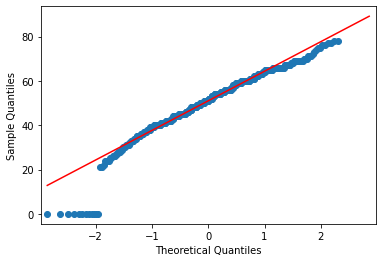

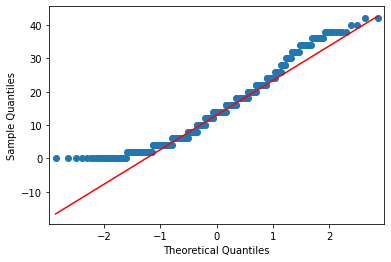

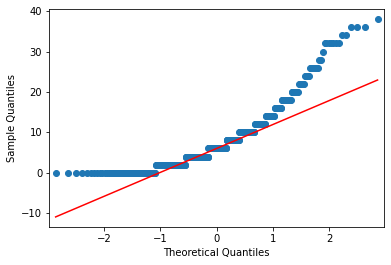

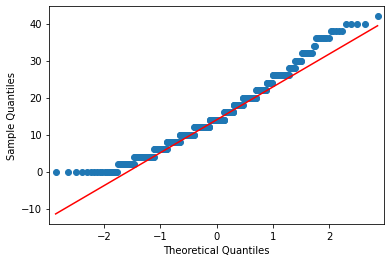

In [20]:
for outcome in ['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']:
    print('\nDisplaying results...\n')
    dt = Data_Explorer(outcome)
    dt.nan_ids(all_dat_df)
    dt.zero_ids(all_dat_df)
    print('Outcome: {}'.format(dt.response_name))
    print(f'There are {len(dt.zero_ids)} zeros in response variable {dt.response_name}.')
    print(f'There are {len(dt.nan_ids)} NaNs in response variable {dt.response_name}.')

    dt.visualize_dist()

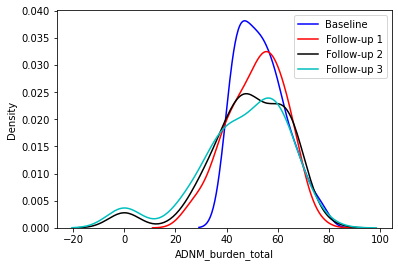

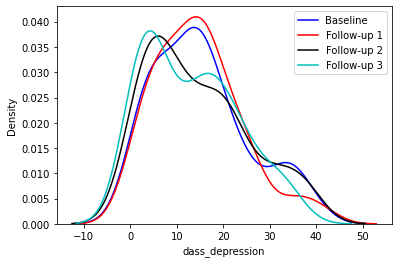

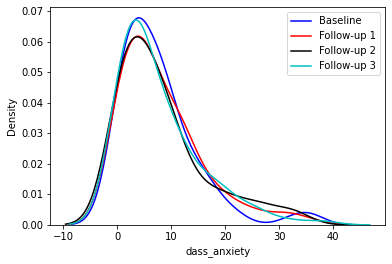

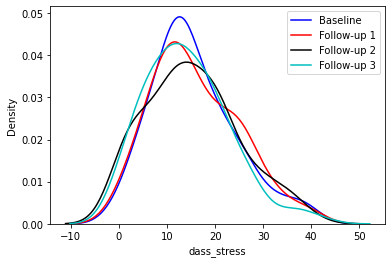

In [21]:
for i,outcome in enumerate(['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']):
    dt = Data_Explorer(outcome)
    colors = ['b','r','k','c']
    names = ['Baseline','Follow-up 1', 'Follow-up 2','Follow-up 3']
    plt.figure(i)
    dt.draw_kdeplot(all_dat_df,names, colors)

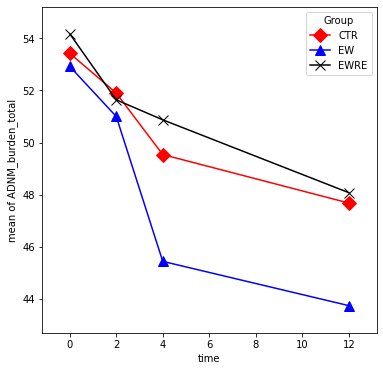

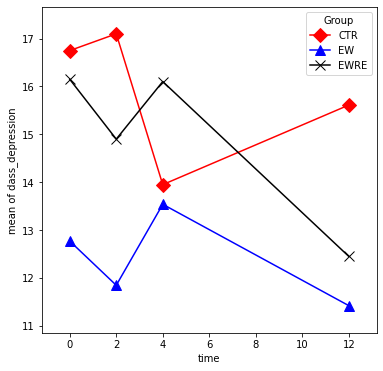

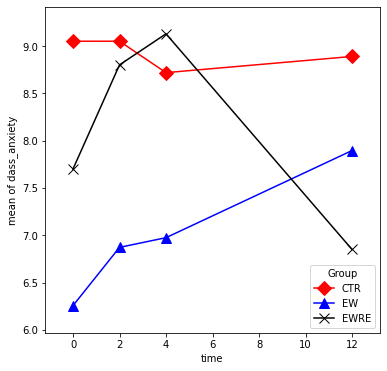

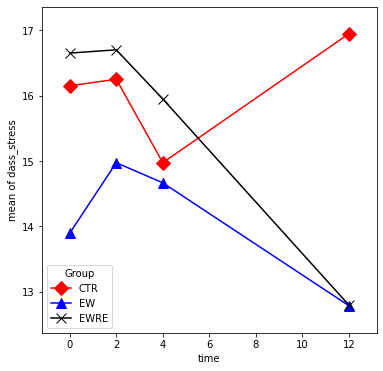

In [22]:
for outcome in ['ADNM_burden_total','dass_depression','dass_anxiety','dass_stress']:
    dt = Data_Explorer(outcome)
    dt.draw_mean_trajectories(all_dat_df)

In [126]:
# check whether scores are significantly different at baseline
for i, outcome in enumerate(['ADNM_burden_total', 'dass_depression', 'dass_anxiety', 'dass_stress', 'ERQ_reapp','ERQ_sup','RRS_total']):
    data = [all_dat_df.loc[(all_dat_df.Group.isin(['EW','EWRE']))&(all_dat_df.time == 0),outcome].dropna().values,all_dat_df.loc[(all_dat_df.Group == 'CTR') &(all_dat_df.time ==0),outcome].dropna().values]
    print('Outcome:{},\nstats: {}\n'.format(outcome, stats.kruskal(data[0],data[1])))
    print('Posthoc:\n1 = EW, 3 = CTR\n {}\n'.format(sp.posthoc_dunn(data, p_adjust = 'bonferroni')))

Outcome:ADNM_burden_total,
stats: KruskalResult(statistic=0.17369314944962796, pvalue=0.6768502313466718)

Posthoc:
1 = EW, 3 = CTR
          1        2
1  1.00000  0.67685
2  0.67685  1.00000

Outcome:dass_depression,
stats: KruskalResult(statistic=1.7127808379438691, pvalue=0.19062496815948377)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.190625
2  0.190625  1.000000

Outcome:dass_anxiety,
stats: KruskalResult(statistic=2.299515648489076, pvalue=0.12941434884273248)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.129414
2  0.129414  1.000000

Outcome:dass_stress,
stats: KruskalResult(statistic=0.06459009406178311, pvalue=0.79938291162651)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.799383
2  0.799383  1.000000

Outcome:ERQ_reapp,
stats: KruskalResult(statistic=2.790688296593056, pvalue=0.094813494934288)

Posthoc:
1 = EW, 3 = CTR
           1         2
1  1.000000  0.094813
2  0.094813  1.000000

Outcome:ERQ_sup,
stats: KruskalRe

In [317]:
# get simulated data & prepare a dataframe for the analysis below.
ERQ_sim = simulate_to_predict(all_dat_df.ERQ_reapp)
model_df = pd.DataFrame({'id':all_dat_df.id,'time':all_dat_df.time,'Group':all_dat_df.Group})
model_df['ERQ_reapp_scaled'] = StandardScaler().fit_transform(np.array(ERQ_sim).reshape(-1,1))
ERQ_sup_sim = simulate_to_predict(all_dat_df.ERQ_sup)
model_df['ERQ_sup_scaled'] = StandardScaler().fit_transform(np.array(ERQ_sup_sim).reshape(-1,1))
RRS_sim = simulate_to_predict(all_dat_df.RRS_total)
model_df['RRS_scaled'] = StandardScaler().fit_transform(np.array(RRS_sim).reshape(-1,1))

ADNM 20 scores - analysis

Because the active groups did not differ significantly in terms of their writing, we will treat them as one group.

In [23]:
all_dat_df['Group_act_v_ctr'] = all_dat_df.Group.replace('EWRE','EW')
all_dat_df.groupby('time').Group_act_v_ctr.value_counts()

time  Group_act_v_ctr
0.0   EW                 79
      CTR                40
2.0   EW                 79
      CTR                40
4.0   EW                 78
      CTR                39
12.0  EW                 78
      CTR                36
Name: Group_act_v_ctr, dtype: int64

In [133]:
# Model mean response structure using a Tweedie distribution, link is log, covariance structure is AR(1)
model_tweedie_adnm = smf.gee("ADNM_burden_total ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

In [134]:
# compare QIC/QICu between different covariance structures.
adnm_qic_df = get_qic_table(all_dat_df, "ADNM_burden_total ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))","id",sm.families.Tweedie())
print(adnm_qic_df)

  dependency type          QIC        QICu
0    Independence  1387.926626  616.740255
1    Exchangeable  1377.220799  617.461643
2  Autoregressive  1404.219462  616.936583


In [135]:
model_tweedie_adnm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                               Results: GEE
==========================================================================================================
Model:                             GEE                             AIC:                          nan      
Link Function:                     log                             BIC:                          -423.4140
Dependent Variable:                ADNM_burden_total               Log-Likelihood:               nan      
Date:                              2021-12-07 16:22                LL-Null:                      nan      
No. Observations:                  465                             Deviance:                     2383.5   
Df Model:                          7                               Pearson chi2:                 1.81e+03 
Df Residuals:                      457                             Scale:                        3.9663   
Method:                            IRLS                                                                   
----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                                   3.9691   0.0322 123.3025 0.0000  3.9060 4.0321
C(time)[T.2.0]                                             -0.0339   0.0368  -0.9220 0.3565 -0.1060 0.0382
C(time)[T.4.0]                                             -0.0618   0.0453  -1.3655 0.1721 -0.1505 0.0269
C(time)[T.12.0]                                            -0.1028   0.0591  -1.7403 0.0818 -0.2187 0.0130
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                 -0.0051   0.0375  -0.1350 0.8926 -0.0786 0.0685
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]   0.0183   0.0447   0.4100 0.6818 -0.0693 0.1059
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]  -0.0276   0.0561  -0.4915 0.6230 -0.1375 0.0824
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW] -0.0287   0.0718  -0.3999 0.6892 -0.1693 0.1119
==========================================================================================================

"""

Include chronicity in model:

In [33]:
all_dat_df.loc[(all_dat_df.order == 1),'same_event'] = 1
all_ids = []
for pnum in all_dat_df.id.unique():
    if all_dat_df.loc[all_dat_df['id']==pnum,'same_event'].sum()==4:
        all_ids.append(pnum)
    else:
        continue
all_dat_df['all_same'] = 0
all_dat_df.loc[all_dat_df.id.isin(all_ids),'all_same'] = 1

In [42]:
# Model mean response structure using a Tweedie distribution, link is log, covariance structure is AR(1)
model_tweedie_adnm_chronicity = smf.gee("ADNM_burden_total ~ C(time) + C(Group_act_v_ctr, Treatment('CTR'))+all_same","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

In [43]:
print(model_tweedie_adnm_chronicity.summary2())

                                       Results: GEE
Model:                        GEE                        AIC:                     nan      
Link Function:                log                        BIC:                     -516.1396
Dependent Variable:           ADNM_burden_total          Log-Likelihood:          nan      
Date:                         2021-12-07 10:53           LL-Null:                 nan      
No. Observations:             465                        Deviance:                2303.1   
Df Model:                     5                          Pearson chi2:            1.78e+03 
Df Residuals:                 459                        Scale:                   3.8735   
Method:                       IRLS                                                         
-------------------------------------------------------------------------------------------
                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------

In [46]:
print(model_tweedie_adnm_chronicity.qic())
print(model_tweedie_adnm.qic())

(1334.0018358729767, 606.562729530398)
(1199.6452374061696, 614.9633017183126)


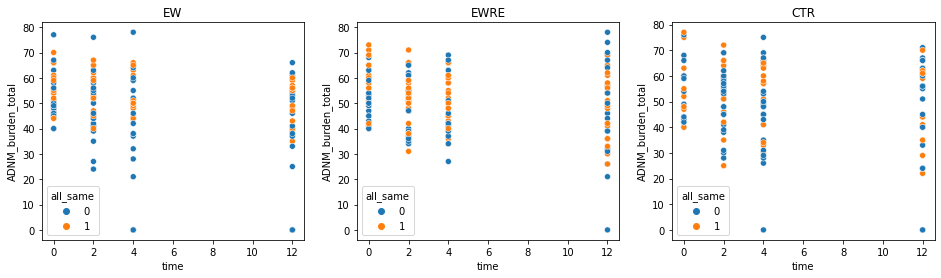

In [123]:
all_dat_df.loc[(all_dat_df.all_same==1)&(all_dat_df.order.isin([2,3,4])),'Group'].value_counts() # get an idea of numbers
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)
for i,group in enumerate(['EW','EWRE','CTR']):
    axes[i].title.set_text(group)
    sns.scatterplot(all_dat_df.time, all_dat_df.loc[all_dat_df.Group == group,'ADNM_burden_total'], hue = all_dat_df.all_same,ax = axes[i])

Some basic model checks

Plotting fitted against residuals. Note that residuals need not be normally distributed for GEEs. We are looking for two main things:
(i) Are there any obvious non-linearities?
(ii) Inspect the variance of the residuals with respect to the fitted values. Look for non-constant variance, which would require a change in the model.
Heree things look decent apart from the obvs outlier.

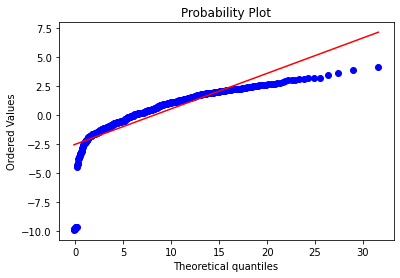

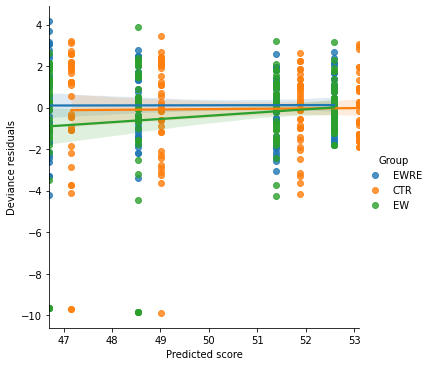

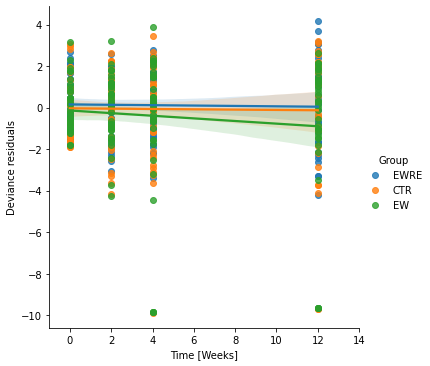

In [111]:
model_checks(all_dat_df,['ADNM_burden_total','id','time','Group'],'ADNM_burden_total',model_tweedie_adnm)

In [ ]:
model_checks(all_dat_df,['ADNM_burden_total','id','time','Group'],'ADNM_burden_total',model_tweedie_adnm_chronicity)

In [116]:
cooks_distance = cooks_d(all_dat_df, "ADNM_burden_total ~ C(time) * C(Group, Treatment('CTR'))", "id", sm.cov_struct.Autoregressive(), sm.families.Tweedie(), model_tweedie_adnm,5)

In [ ]:
# We use a threshold of 3* the mean of the cluster cook statistics for all subjects.
thresh_cal = cooks_distance.cooks_distance.mean()*3
print(thresh_cal)
subs_to_remove = cooks_distance[cooks_distance.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_adnm_red = smf.gee("ADNM_burden_total ~ C(time) + C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance['above_threshold'] = 0
cooks_distance.loc[cooks_distance.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

We can have a look at the score for the participants who were marked as outliers above.

In [ ]:
all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),['ADNM_burden_total','order','id']].set_index('id').sort_index().reset_index()

Moderator analysis - ERQ reapp/sup, RRS scores

In [147]:
# Model mean response structure using a Tweedie distribution, link is log, covariance structure is AR(1)
model_erq_adnm = smf.gee("ADNM_burden_total ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))*ERQ_reapp_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

In [149]:
model_tweedie_adnm.qic()

(1404.2194619599634, 616.9365832206809)

In [146]:
# compare QIC/QICu between different covariance structures.
adnm_qic_df = get_qic_table(all_dat_df, "ADNM_burden_total ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))*ERQ_reapp_scaled","id",sm.families.Tweedie())
print(adnm_qic_df)

  dependency type          QIC        QICu
0    Independence  2140.391992  626.441680
1    Exchangeable  2009.465627  625.598165
2  Autoregressive  2058.748475  625.207716


In [148]:
model_erq_adnm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                        Results: GEE
============================================================================================================================
Model:                                   GEE                                   AIC:                                nan      
Link Function:                           log                                   BIC:                                -412.4643
Dependent Variable:                      ADNM_burden_total                     Log-Likelihood:                     nan      
Date:                                    2021-12-07 16:30                      LL-Null:                            nan      
No. Observations:                        465                                   Deviance:                           2345.3   
Df Model:                                15                                    Pearson chi2:                       1.78e+03 
Df Residuals:                            449                                   Scale:                              3.9536   
Method:                                  IRLS                                                                               
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    3.9500   0.0329 120.2069 0.0000  3.8856  4.0144
C(time)[T.2.0]                                                              -0.0123   0.0371  -0.3316 0.7402 -0.0851  0.0605
C(time)[T.4.0]                                                              -0.0426   0.0470  -0.9057 0.3651 -0.1347  0.0496
C(time)[T.12.0]                                                             -0.0922   0.0591  -1.5603 0.1187 -0.2081  0.0236
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                                   0.0159   0.0380   0.4172 0.6765 -0.0587  0.0904
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                   -0.0041   0.0440  -0.0924 0.9264 -0.0903  0.0822
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                   -0.0488   0.0573  -0.8506 0.3950 -0.1611  0.0636
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                  -0.0418   0.0717  -0.5826 0.5602 -0.1822  0.0987
ERQ_reapp_scaled                                                            -0.0732   0.0270  -2.7090 0.0067 -0.1262 -0.0202
C(time)[T.2.0]:ERQ_reapp_scaled                                              0.0306   0.0340   0.9002 0.3680 -0.0360  0.0971
C(time)[T.4.0]:ERQ_reapp_scaled                                              0.0815   0.0425   1.9184 0.0551 -0.0018  0.1647
C(time)[T.12.0]:ERQ_reapp_scaled                                             0.0181   0.0461   0.3922 0.6949 -0.0722  0.1083
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled                  0.0732   0.0323   2.2663 0.0234  0.0099  0.1366
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled  -0.0580   0.0401  -1.4476 0.1477 -0.1366  0.0205
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled  -0.0717   0.0584  -1.2272 0.2197 -0.1861  0.0428
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled -0.0098   0.0693  -0.1421 0.8870 -0.1457  0.1260
============================================================================================================================

"""

To further explore the possible moderation effect of ERQ, we simulate some data for representative groups (mean +/-1 std) and predict ADNM scores.

We will now simulate ERQ scores in the range +/- 1 std deviation from the mean and predict ADNM-20 scores for these data points using the coefficients from our model.

In [361]:
# get simulated data
predictions = model_erq_adnm.predict(exog = model_df)
model_df['predicted_ADNM'] = predictions


Plot predicted scores for each group and assessment time point.

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_ADNM'>

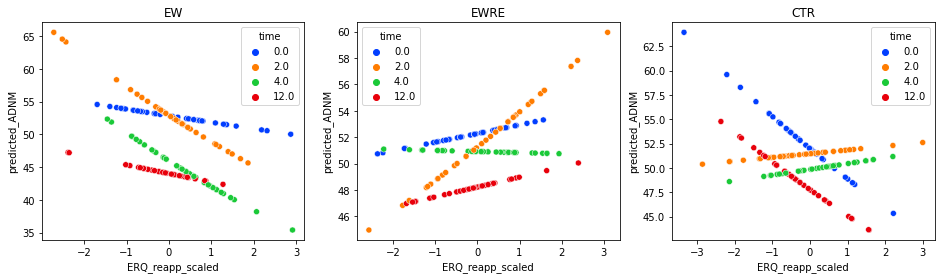

In [364]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')
sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_ADNM'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_ADNM'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_ADNM'],hue = model_df.time,palette = 'bright', ax = axes[0])


To visualise further, we will create a categorical variable to divide participants into low/med/high ERQ scorers. We will then plot trajectories of ADNM-20 scores over time for each ERQ/writing group.

In [365]:
all_dat_df['ERQ_reapp_cat'] = 1
all_dat_df.loc[all_dat_df.ERQ_reapp>(all_dat_df.ERQ_reapp.mean()+all_dat_df.ERQ_reapp.std()),'ERQ_reapp_cat'] = 2
all_dat_df.loc[all_dat_df.ERQ_reapp<(all_dat_df.ERQ_reapp.mean()-all_dat_df.ERQ_reapp.std()),'ERQ_reapp_cat'] = 0

We will also create categorical variables for ERQ-expressive suppresion and RRS.

In [366]:
all_dat_df['ERQ_sup_cat'] = 1
all_dat_df.loc[all_dat_df.ERQ_sup>(all_dat_df.ERQ_sup.mean()+all_dat_df.ERQ_sup.std()),'ERQ_sup_cat'] = 2
all_dat_df.loc[all_dat_df.ERQ_sup<(all_dat_df.ERQ_sup.mean()-all_dat_df.ERQ_sup.std()),'ERQ_sup_cat'] = 0

In [367]:
all_dat_df['RRS_cat'] = 1
all_dat_df.loc[all_dat_df.RRS_total>(all_dat_df.RRS_total.mean()+all_dat_df.RRS_total.std()),'RRS_cat'] = 2
all_dat_df.loc[all_dat_df.RRS_total<(all_dat_df.RRS_total.mean()-all_dat_df.RRS_total.std()),'RRS_cat'] = 0

In [ ]:
all_dat_df.loc[all_dat_df.ERQ_reapp_cat == 0,:].groupby('time').ADNM_burden_total.mean()

time
0.0     55.166667
2.0     52.555556
4.0     50.823529
12.0    50.000000
Name: ADNM_burden_total, dtype: float64

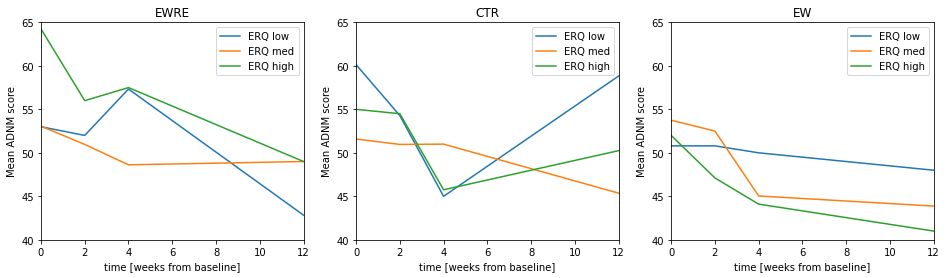

In [371]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').ADNM_burden_total.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').ADNM_burden_total.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').ADNM_burden_total.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([40,65])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean ADNM score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])

DASS subscales

In [ ]:
red_dass_df = all_dat_df.loc[:,['dass_depression','time','id','Group']]
drop_inds = red_dass_df.loc[red_dass_df.dass_depression.isna(),:].index.values
red_dass_df = red_dass_df.drop(labels = drop_inds, axis = 0)

Use Tweedie distribution + log link + Autoregressive 

In [151]:
model_tweedie_dassd= smf.gee("dass_depression ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_tweedie_dassd.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: GEE
=========================================================================================================
Model:                              GEE                            AIC:                          nan     
Link Function:                      log                            BIC:                          699.1751
Dependent Variable:                 dass_depression                Log-Likelihood:               nan     
Date:                               2021-12-07 16:40               LL-Null:                      nan     
No. Observations:                   469                            Deviance:                     3534.6  
Df Model:                           7                              Pearson chi2:                 3.31e+03
Df Residuals:                       461                            Scale:                        7.1746  
Method:                             IRLS                                                                 
---------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                                   2.8094   0.0945 29.7220 0.0000  2.6242 2.9947
C(time)[T.2.0]                                              0.0295   0.1052  0.2800 0.7795 -0.1767 0.2356
C(time)[T.4.0]                                             -0.1990   0.1147 -1.7345 0.0828 -0.4238 0.0259
C(time)[T.12.0]                                            -0.0264   0.1122 -0.2357 0.8137 -0.2463 0.1934
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                 -0.1315   0.1252 -1.0506 0.2934 -0.3769 0.1138
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]  -0.0943   0.1281 -0.7364 0.4615 -0.3453 0.1567
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]   0.2063   0.1446  1.4265 0.1537 -0.0772 0.4898
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW] -0.1829   0.1568 -1.1659 0.2436 -0.4903 0.1245
=========================================================================================================

"""

Below we check whether an alternative covariance structure would make sense.

In [163]:
# compare QIC/QICu between different covariance structures.
dassd_qic_df = get_qic_table(all_dat_df, "dass_depression ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))","id",sm.families.Tweedie())
print(dassd_qic_df)

  dependency type         QIC        QICu
0    Independence  716.463652  509.286921
1    Exchangeable  717.787439  510.122102
2  Autoregressive  725.809771  508.657792


Model diagnostics (half normal plot, fitted/residuals, time/residuals)

In [164]:
model_erq_dassd.qic()

(864.9704686177913, 507.13731280569147)

In [ ]:
model_checks(all_dat_df,['dass_depression','id','time','Group'],'dass_depression',model_tweedie_dassd)

In [153]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_tweedie_dassd_red = smf.gee("dass_depression ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()
    # get coefficients
    diff_full = abs(model_tweedie_dassd.fittedvalues-model_tweedie_dassd_red.fittedvalues)
    cooks_d = np.sum(np.square(diff_full))/(5*np.mean(np.square(model_tweedie_dassd.resid_deviance)))
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

In [ ]:
# threshold = 3*mean(cluster cook statistic)
thresh_cal = cooks_distance_df.cooks_distance.mean()*3
print(thresh_cal)
subs_to_remove = cooks_distance_df[cooks_distance_df.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_dassd_red = smf.gee("dass_depression ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance_df['above_threshold'] = 0
cooks_distance_df.loc[cooks_distance_df.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance_df, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

Check scores for subjects flagged as outliers.

In [ ]:
all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),['dass_depression','order','id']].set_index('id').sort_index()

In [155]:
model_erq_dassd= smf.gee("dass_depression ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))*ERQ_reapp_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie()).fit()
model_erq_dassd.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: GEE
===========================================================================================================================
Model:                                    GEE                                  AIC:                                nan     
Link Function:                            log                                  BIC:                                556.5930
Dependent Variable:                       dass_depression                      Log-Likelihood:                     nan     
Date:                                     2021-12-07 16:44                     LL-Null:                            nan     
No. Observations:                         469                                  Deviance:                           3342.8  
Df Model:                                 15                                   Pearson chi2:                       3.19e+03
Df Residuals:                             453                                  Scale:                              7.0355  
Method:                                   IRLS                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    2.7288   0.0962 28.3583 0.0000  2.5402  2.9174
C(time)[T.2.0]                                                               0.1036   0.1013  1.0223 0.3066 -0.0950  0.3021
C(time)[T.4.0]                                                              -0.1483   0.1328 -1.1171 0.2640 -0.4086  0.1119
C(time)[T.12.0]                                                              0.0226   0.1241  0.1825 0.8552 -0.2205  0.2658
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                                  -0.0543   0.1267 -0.4289 0.6680 -0.3026  0.1940
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                   -0.1585   0.1242 -1.2759 0.2020 -0.4020  0.0850
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                    0.1500   0.1608  0.9333 0.3507 -0.1650  0.4651
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                  -0.2257   0.1662 -1.3583 0.1744 -0.5514  0.1000
ERQ_reapp_scaled                                                            -0.2301   0.0828 -2.7787 0.0055 -0.3923 -0.0678
C(time)[T.2.0]:ERQ_reapp_scaled                                              0.1251   0.0845  1.4800 0.1389 -0.0406  0.2907
C(time)[T.4.0]:ERQ_reapp_scaled                                              0.1414   0.1195  1.1833 0.2367 -0.0928  0.3756
C(time)[T.12.0]:ERQ_reapp_scaled                                             0.1285   0.1239  1.0379 0.2993 -0.1142  0.3713
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled                  0.1388   0.1114  1.2468 0.2125 -0.0794  0.3571
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled  -0.1220   0.1105 -1.1039 0.2696 -0.3385  0.0946
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled  -0.1938   0.1538 -1.2597 0.2078 -0.4953  0.1077
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:ERQ_reapp_scaled -0.1923   0.1768 -1.0879 0.2766 -0.5388  0.1542
===========================================================================================================================

"""

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_dassd'>

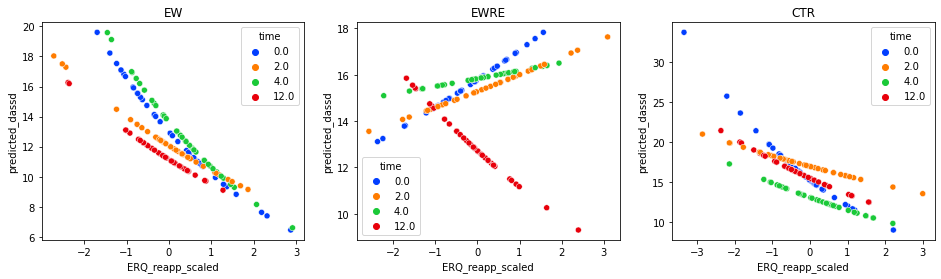

In [381]:
predictions = model_erq_dassd.predict(exog = model_df)
model_df['predicted_dassd'] = predictions
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')
sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_dassd'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_dassd'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_dassd'],hue = model_df.time,palette = 'bright', ax = axes[0])

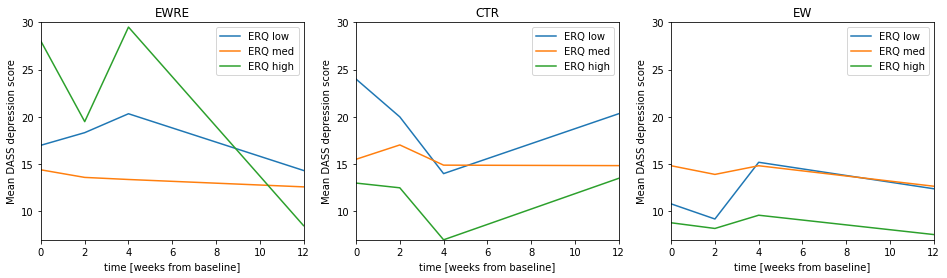

In [384]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').dass_depression.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').dass_depression.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').dass_depression.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([7,30])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean DASS depression score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])


DASS anxiety

In [180]:
model_tweedie_dassa = smf.gee("dass_anxiety~ C(time)* C(Group_act_v_ctr, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie()).fit()
model_tweedie_dassa.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: GEE
=========================================================================================================
Model:                              GEE                            AIC:                          nan     
Link Function:                      log                            BIC:                          371.8582
Dependent Variable:                 dass_anxiety                   Log-Likelihood:               nan     
Date:                               2021-12-07 17:21               LL-Null:                      nan     
No. Observations:                   469                            Deviance:                     3207.3  
Df Model:                           7                              Pearson chi2:                 3.41e+03
Df Residuals:                       461                            Scale:                        7.3935  
Method:                             IRLS                                                                 
---------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                                   2.2028   0.1395 15.7850 0.0000  1.9293 2.4763
C(time)[T.2.0]                                              0.0000   0.0970  0.0000 1.0000 -0.1900 0.1900
C(time)[T.4.0]                                             -0.0374   0.1299 -0.2877 0.7736 -0.2920 0.2173
C(time)[T.12.0]                                            -0.0180   0.1213 -0.1481 0.8823 -0.2557 0.2198
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                 -0.2587   0.1767 -1.4636 0.1433 -0.6050 0.0877
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]   0.1162   0.1232  0.9426 0.3459 -0.1254 0.3577
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]   0.1791   0.1710  1.0474 0.2949 -0.1561 0.5143
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]  0.0698   0.1635  0.4268 0.6695 -0.2507 0.3903
=========================================================================================================

"""

In [158]:
print(model_tweedie_dassa.qic())

(563.9209402117046, 449.53138886949836)


In [162]:
# compare QIC/QICu between different covariance structures.
dassa_qic_df = get_qic_table(all_dat_df, "dass_anxiety ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))","id",sm.families.Tweedie())
print(dassa_qic_df)

  dependency type         QIC        QICu
0    Independence  563.392933  449.796519
1    Exchangeable  563.920940  449.531389
2  Autoregressive  565.903342  447.820231


In [182]:
model_erq_dassa.qic()

(674.8749954068638, 462.7815592808961)

In [ ]:
model_checks(all_dat_df,['dass_anxiety','id','time','Group'],'dass_anxiety',model_tweedie_dassa)

In [394]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_tweedie_dassa_red = smf.gee("dass_anxiety ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie(),missing = 'drop').fit()
    # get coefficients
    diff_full = abs(model_tweedie_dassa.fittedvalues-model_tweedie_dassa_red.fittedvalues)
    cooks_d = np.sum(np.square(diff_full))/(5*np.mean(np.square(model_tweedie_dassa.resid_deviance)))
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

In [ ]:
# to calculate the threshold, we use the formula 3p/(n*T), where p = number of predictors, n = number of clusters, T = number of measurements for each cluster
#thresh_cal = (3*2)/(119*5)
thresh_cal = cooks_distance_df.cooks_distance.mean()*3
print(thresh_cal)
# Way to high. Possibly I got this wrong. I'll just choose a threshold by inspection for the moment.
thresh = 0.0005
subs_to_remove = cooks_distance_df[cooks_distance_df.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_dassa_red = smf.gee("dass_anxiety ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance_df['above_threshold'] = 0
cooks_distance_df.loc[cooks_distance_df.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance_df, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

Exploratory analysis - add moderators

In [183]:
model_erq_dassa = smf.gee("dass_anxiety~ C(time)* C(Group_act_v_ctr, Treatment('CTR'))*RRS_total_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie()).fit()
model_erq_dassa.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: GEE
===========================================================================================================================
Model:                                   GEE                                  AIC:                                nan      
Link Function:                           log                                  BIC:                                -237.7080
Dependent Variable:                      dass_anxiety                         Log-Likelihood:                     nan      
Date:                                    2021-12-07 17:22                     LL-Null:                            nan      
No. Observations:                        469                                  Deviance:                           2548.5   
Df Model:                                15                                   Pearson chi2:                       2.56e+03 
Df Residuals:                            453                                  Scale:                              5.6466   
Method:                                  IRLS                                                                              
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    2.1666   0.1282 16.8957 0.0000  1.9152  2.4179
C(time)[T.2.0]                                                              -0.0208   0.1084 -0.1919 0.8479 -0.2332  0.1916
C(time)[T.4.0]                                                              -0.0790   0.1364 -0.5792 0.5625 -0.3463  0.1883
C(time)[T.12.0]                                                             -0.0102   0.1186 -0.0859 0.9316 -0.2427  0.2223
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                                  -0.3549   0.1610 -2.2049 0.0275 -0.6705 -0.0394
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                    0.0863   0.1444  0.5980 0.5498 -0.1966  0.3693
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                    0.2935   0.1759  1.6685 0.0952 -0.0513  0.6382
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                   0.1136   0.1599  0.7106 0.4774 -0.1998  0.4271
RRS_total_scaled                                                             0.3185   0.0929  3.4261 0.0006  0.1363  0.5006
C(time)[T.2.0]:RRS_total_scaled                                              0.0094   0.0943  0.1002 0.9202 -0.1754  0.1943
C(time)[T.4.0]:RRS_total_scaled                                              0.0391   0.1410  0.2772 0.7816 -0.2372  0.3154
C(time)[T.12.0]:RRS_total_scaled                                            -0.0273   0.0984 -0.2771 0.7817 -0.2201  0.1656
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled                  0.1751   0.1303  1.3442 0.1789 -0.0802  0.4305
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled   0.0542   0.1338  0.4053 0.6852 -0.2080  0.3165
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled  -0.1900   0.1837 -1.0344 0.3009 -0.5499  0.1700
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled  0.0148   0.1453  0.1016 0.9191 -0.2701  0.2996
===========================================================================================================================

"""

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_dassa'>

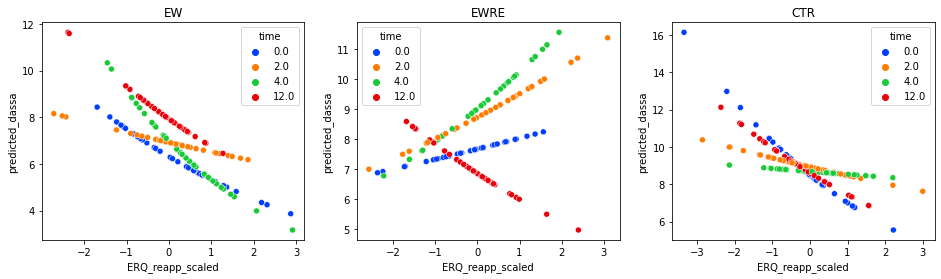

In [390]:
predictions = model_erq_dassa.predict(exog = model_df)
model_df['predicted_dassa'] = predictions
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')
sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_dassa'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_dassa'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_dassa'],hue = model_df.time,palette = 'bright', ax = axes[0])

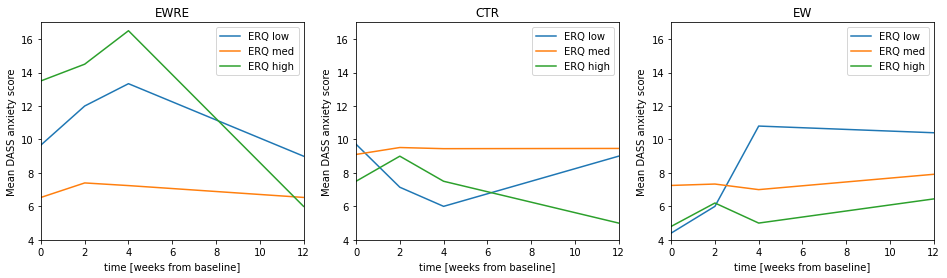

In [393]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').dass_anxiety.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').dass_anxiety.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').dass_anxiety.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([4,17])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean DASS anxiety score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])



DASS stress

In [170]:
model_tweedie_dasss = smf.gee("dass_stress~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie()).fit()
model_tweedie_dasss.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                               Results: GEE
==========================================================================================================
Model:                              GEE                            AIC:                          nan      
Link Function:                      log                            BIC:                          -141.3423
Dependent Variable:                 dass_stress                    Log-Likelihood:               nan      
Date:                               2021-12-07 17:07               LL-Null:                      nan      
No. Observations:                   469                            Deviance:                     2694.1   
Df Model:                           7                              Pearson chi2:                 2.48e+03 
Df Residuals:                       461                            Scale:                        5.3727   
Method:                             IRLS                                                                  
----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                                   2.7819   0.0910 30.5559 0.0000  2.6035  2.9604
C(time)[T.2.0]                                              0.0062   0.0840  0.0734 0.9414 -0.1586  0.1709
C(time)[T.4.0]                                             -0.0756   0.0892 -0.8476 0.3967 -0.2504  0.0992
C(time)[T.12.0]                                             0.0480   0.0785  0.6118 0.5406 -0.1058  0.2018
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                 -0.0546   0.1101 -0.4965 0.6196 -0.2704  0.1611
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]   0.0296   0.1014  0.2919 0.7704 -0.1692  0.2284
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]   0.0767   0.1079  0.7102 0.4776 -0.1349  0.2882
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW] -0.2262   0.1066 -2.1221 0.0338 -0.4352 -0.0173
==========================================================================================================

"""

In [169]:
# compare QIC/QICu between different covariance structures.
dasss_qic_df = get_qic_table(all_dat_df, "dass_stress ~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))","id",sm.families.Tweedie())
print(dasss_qic_df)

  dependency type         QIC        QICu
0    Independence  752.072918  517.439691
1    Exchangeable  749.713167  518.019640
2  Autoregressive  762.070905  519.805603


In [177]:
model_erq_dasss.qic()

(1057.4962514160375, 532.419683723489)

In [ ]:
model_checks(all_dat_df,['dass_stress','id','time','Group'],'dass_stress',model_tweedie_dasss)

In [406]:
# Calculate Cook's distance. This attempts to answer the question, "If we exclude participant X from the analysis, how would the coefficient estimates be affected?"
# We'll do the following: Exclude participant x - repeat analysis - calculate change in coefficients (abs) - record - repeat, excluding next participan in line.
# This will take ages for more complex models but I couldn't find an implementation I was happy with.
cooks_dist = []
all_ids = []
for i,pnum in enumerate(all_dat_df.id.unique()):
    # eliminate id from dataframe
    red_df = all_dat_df.drop(labels = all_dat_df.loc[all_dat_df.id == pnum].index.values,axis = 0)
    # fit model
    model_tweedie_dasss_red = smf.gee("dass_stress ~ C(time) * C(Group, Treatment('CTR'))","id", red_df, cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()
    # get coefficients
    diff_full = abs(model_tweedie_dasss.fittedvalues-model_tweedie_dasss_red.fittedvalues)
    cooks_d = np.sum(np.square(diff_full))/(5*np.mean(np.square(model_tweedie_dasss.resid_deviance)))
    cooks_dist.append(cooks_d)
    all_ids.append(pnum)

cooks_distance_df = pd.DataFrame({'id':all_ids,'cooks_distance':cooks_dist})

0.8957591895283655
[44 57 64 87 89]


<AxesSubplot:xlabel='id', ylabel='cooks_distance'>

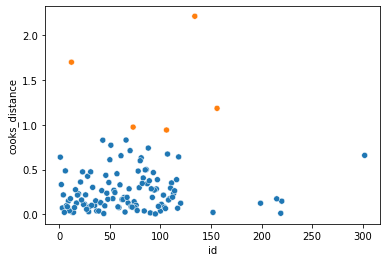

In [407]:
# threshold = 3*mean
thresh_cal = cooks_distance_df.cooks_distance.mean()*3
print(thresh_cal)
# Way to high. Possibly I got this wrong. I'll just choose a threshold by inspection for the moment.
thresh = 0.0005
subs_to_remove = cooks_distance_df[cooks_distance_df.cooks_distance>thresh_cal].index.values
print(subs_to_remove)
inds_to_drop = all_dat_df.loc[all_dat_df.id.isin(subs_to_remove),:].index.values
# now remove and re-run analysis:
model_tweedie_dasss_red = smf.gee("dass_stress ~ C(time) * C(Group, Treatment('CTR'))","id", all_dat_df.drop(labels = inds_to_drop, axis = 0), cov_struct = sm.cov_struct.Autoregressive(), family = sm.families.Tweedie(),missing = 'drop').fit()

cooks_distance_df['above_threshold'] = 0
cooks_distance_df.loc[cooks_distance_df.cooks_distance>thresh_cal,'above_threshold']=1
sns.scatterplot(data=cooks_distance_df, x="id", y="cooks_distance",hue = 'above_threshold',legend = False)

In [176]:
model_erq_dasss = smf.gee("dass_stress~ C(time) * C(Group_act_v_ctr, Treatment('CTR'))*RRS_total_scaled","id", all_dat_df, cov_struct = sm.cov_struct.Independence(), family = sm.families.Tweedie()).fit()
model_erq_dasss.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: GEE
===========================================================================================================================
Model:                                   GEE                                  AIC:                                nan      
Link Function:                           log                                  BIC:                                -563.7762
Dependent Variable:                      dass_stress                          Log-Likelihood:                     nan      
Date:                                    2021-12-07 17:12                     LL-Null:                            nan      
No. Observations:                        469                                  Deviance:                           2222.4   
Df Model:                                15                                   Pearson chi2:                       2.01e+03 
Df Residuals:                            453                                  Scale:                              4.4412   
Method:                                  IRLS                                                                              
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    2.7518   0.0824 33.3815 0.0000  2.5902  2.9134
C(time)[T.2.0]                                                               0.0255   0.0798  0.3196 0.7492 -0.1309  0.1819
C(time)[T.4.0]                                                              -0.0833   0.0867 -0.9606 0.3367 -0.2532  0.0866
C(time)[T.12.0]                                                              0.0682   0.0771  0.8850 0.3761 -0.0828  0.2192
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                                  -0.0821   0.0987 -0.8315 0.4057 -0.2756  0.1114
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                    0.0133   0.0990  0.1342 0.8933 -0.1808  0.2073
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                    0.1183   0.1078  1.0967 0.2728 -0.0931  0.3296
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]                  -0.2099   0.0994 -2.1123 0.0347 -0.4047 -0.0151
RRS_total_scaled                                                             0.2927   0.0896  3.2678 0.0011  0.1172  0.4683
C(time)[T.2.0]:RRS_total_scaled                                             -0.1556   0.0690 -2.2558 0.0241 -0.2908 -0.0204
C(time)[T.4.0]:RRS_total_scaled                                             -0.0358   0.0906 -0.3958 0.6922 -0.2134  0.1417
C(time)[T.12.0]:RRS_total_scaled                                            -0.0864   0.0727 -1.1882 0.2348 -0.2290  0.0561
C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled                  0.0170   0.1074  0.1580 0.8745 -0.1936  0.2275
C(time)[T.2.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled   0.1143   0.0959  1.1912 0.2336 -0.0737  0.3023
C(time)[T.4.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled  -0.0492   0.1214 -0.4056 0.6850 -0.2872  0.1887
C(time)[T.12.0]:C(Group_act_v_ctr, Treatment('CTR'))[T.EW]:RRS_total_scaled  0.0604   0.1077  0.5609 0.5749 -0.1507  0.2714
===========================================================================================================================

"""

<AxesSubplot:title={'center':'EW'}, xlabel='ERQ_reapp_scaled', ylabel='predicted_dasss'>

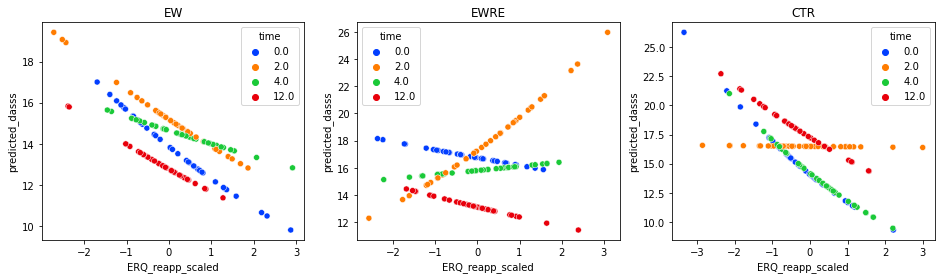

In [401]:
predictions = model_erq_dasss.predict(exog = model_df)
model_df['predicted_dasss'] = predictions
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text('EW')
axes[1].title.set_text('EWRE')
axes[2].title.set_text('CTR')

sns.scatterplot(model_df.loc[model_df.Group=='CTR','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'CTR','predicted_dasss'],hue = model_df.time,palette = 'bright',ax = axes[2])
sns.scatterplot(model_df.loc[model_df.Group=='EWRE','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EWRE','predicted_dasss'],hue = model_df.time,palette = 'bright', ax = axes[1])
sns.scatterplot(model_df.loc[model_df.Group=='EW','ERQ_reapp_scaled'],model_df.loc[model_df.Group == 'EW','predicted_dasss'],hue = model_df.time,palette = 'bright', ax = axes[0])

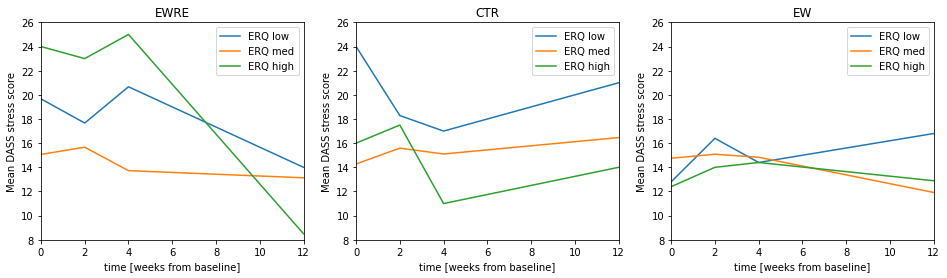

In [405]:
f,axes = plt.subplots(1,3)
f.set_size_inches(16,4)

axes[0].title.set_text(all_dat_df.Group.unique()[0])
axes[1].title.set_text(all_dat_df.Group.unique()[1])
axes[2].title.set_text(all_dat_df.Group.unique()[2])
x_ax = [0,2,4,12]

all_vals = []
for count,group in enumerate(all_dat_df.Group.unique()):
    erq_lo = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 0) & (all_dat_df.Group == group),:].groupby('time').dass_stress.mean()
    erq_med = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 1) & (all_dat_df.Group == group),:].groupby('time').dass_stress.mean()
    erq_hi = all_dat_df.loc[(all_dat_df.ERQ_reapp_cat == 2) & (all_dat_df.Group == group),:].groupby('time').dass_stress.mean()
    all_vals.append(erq_lo)
    all_vals.append(erq_med)
    all_vals.append(erq_hi)


for i in range(0,3):
    axes[i].plot(x_ax, all_vals[i*3])
    axes[i].plot(x_ax, all_vals[i*3+1])
    axes[i].plot(x_ax, all_vals[i*3+2])
    axes[i].set_xlim([0,12])
    axes[i].set_ylim([8,26])
    axes[i].set_xlabel('time [weeks from baseline]')
    axes[i].set_ylabel('Mean DASS stress score')
    axes[i].legend(['ERQ low','ERQ med','ERQ high'])

